# **Recommendations with IBM**

## **Table of Contents**
1. Exploratory Data Analysis
2. Rank Based Recommendations
3. User-User Based Collaborative Filtering
4. Matrix Factorization
5. Extras & Concluding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

data = pd.read_csv('data/user-item-interactions.csv')
data_content = pd.read_csv('data/articles_community.csv')
del data['Unnamed: 0']
del data_content['Unnamed: 0']

# Seeing the data to get an idea about it
data.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Showcasing data_content as well to get an idea of the data
data_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


# **Part I : Exploratory Data Analysis**
Using the dictionary, we provide some insight into the descriptive statistics of the data.

1. What is the distribution of how many articles a user interacts with in the dataset? Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.

In [3]:
#finding total number of interactions done by users
data.shape[0]

45993

In [4]:
#finding number of null values
data.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [5]:
#finding number of unique users and article_id
print(data.email.nunique())
print(data.article_id.nunique())

5148
714


In [6]:
#articles with the most number of interactions
data.groupby('article_id')['email'].count().sort_values(ascending=False).head(10)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
1314.0    614
1293.0    572
1170.0    565
1162.0    512
1304.0    483
Name: email, dtype: int64

In [7]:
popular_articles =pd.DataFrame(data.groupby('article_id')['email'].count().sort_values(ascending=False).head(10))
popular_articles.email.tolist()

[937, 927, 671, 643, 627, 614, 572, 565, 512, 483]

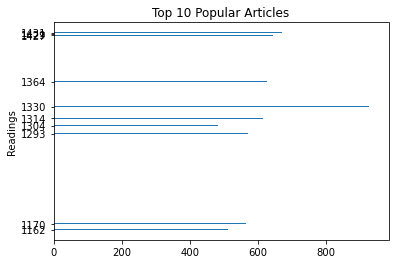

In [8]:
popular_articles =pd.DataFrame(data.groupby('article_id')['email'].count().sort_values(ascending=False).head(10))
x = popular_articles.index.tolist()
y = popular_articles.email.tolist()

plt.barh(x,y)
plt.ylabel('Readings')
plt.title('Top 10 Popular Articles')
plt.yticks(x)

plt.show()

In [9]:
#finding the maximum number of articles read by users
data.groupby('email')['article_id'].count().sort_values(ascending=False).head(10)

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
f8c978bcf2ae2fb8885814a9b85ffef2f54c3c76    158
284d0c17905de71e209b376e3309c0b08134f7e2    148
d9032ff68d0fd45dfd18c0c5f7324619bb55362c    147
18e7255ee311d4bd78f5993a9f09538e459e3fcc    147
c60bb0a50c324dad0bffd8809d121246baef372b    145
Name: article_id, dtype: int64

In [10]:
#finding the average number of articles read by users
data.groupby('email')['article_id'].count().mean()

8.930846930846931

In [11]:
#finding the median by the email
data.groupby('email').count().median()

article_id    3.0
title         3.0
dtype: float64

In [12]:
#filling the values of the median and the maximum number of user_article interactions
median_val = 3
maximum_views_by_user = 364


2. Removing duplicate articles from the **data_content** dataframe.

In [13]:
#finding the number of duplicate articles
print("Number of duplicate articles: {}" .format(data_content.duplicated(subset = 'article_id', keep = 'first').sum()))

Number of duplicate articles: 5


In [14]:
#removing the duplicate articles
data_content = data_content[data_content.duplicated(subset = 'article_id', keep = 'first') == False]

3. We then find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
#number of unique articles on the IBM platform
data_content['article_id'].nunique()

1051

In [16]:
unique_articles = 714
total_articles = 1051
unique_users = 5148
user_article_readings = 45993

4. Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [17]:
data.groupby('article_id')['email'].count().sort_values(ascending=False).head(1)

article_id
1429.0    937
Name: email, dtype: int64

In [18]:
most_viewed_article_id = '1429.0'
maximum_views = 937

In [19]:
#Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in data['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del data['email']
data['user_id'] = email_encoded

# show dataframe
data.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [20]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_readings,
    '`The maximum number of user-article interactions by any 1 user is ______.`': maximum_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': maximum_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Testing our dictionary against the solution dictionary
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


# **Part II: Rank-Based Recommendations**
In this dataset we don't actually have ratings for whether a user liked an article or not. We only know that a user has interacted with an article. In these cases, the popularity of an article can really only be based on how often an article was interacted with.

1. We now return the n top articles ordered with most interactions as the top.

In [21]:
def top_articles(n, data=data):
    '''
    INPUT:
    n - (int) the number of top articles to return
    data - (pandas dataframe) data as defined at the top of the notebook 
    
    OUTPUT:
    list_top_articles - (list) A list of the top 'n' article titles 
    
    '''
    list_top_articles = data[data['article_id'].isin(top_article_id(n, data=data))]['title'].unique().tolist() 
    return list_top_articles

def top_article_id(n, data=data):
    '''
    INPUT:
    n - (int) the number of top articles to return
    data - (pandas dataframe) data as defined at the top of the notebook 
    
    OUTPUT:
    list_top_articles - (list) A list of the top 'n' article titles 
    
    '''
    article_id = data.groupby('article_id')['user_id'].count().sort_values(ascending=False).head(n)
    list_top_articles = article_id.index.values.tolist()
    list_top_articles = list(map(str,list_top_articles))
    return list_top_articles # Return the top article ids

In [22]:
print(top_articles(10))
print(top_article_id(10))

['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for logistic regression model', 'insights from new york car accident reports', 'finding optimal locations of new store using decision optimization']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [23]:
#Testing the function by returning the top 5, 10, and 20 articles
top_5 = top_articles(5)
top_10 = top_articles(10)
top_20 = top_articles(20)

# Test each of your three lists from above
t.sol_2_test(top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


# **Part III: User-User Based Collaborative Filtering**
`1.` We then reformat the **data** dataframe to be shaped with users as the rows and articles as the columns. The following are the conditions kept in mind:  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [24]:
#creating the user-article matrix with 1's and 0's (Binary)

def get_user_item_matrix(data):
    '''
    INPUT:
    data - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_interaction_data = data.groupby(['user_id','article_id']).count()
    for i in range(user_interaction_data.title.shape[0]):
        if user_interaction_data.title.iloc[i] > 0:
            user_interaction_data.title.iloc[i] = 1
    user_item = user_interaction_data.title.unstack()
    user_item.fillna(0,inplace = True)
    user_item_mat = user_item
    return user_item_mat # return the user_item_mat matrix 

user_item_mat = get_user_item_matrix(data)

In [25]:
## Testing our user matrix:
assert user_item_mat.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item_mat.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item_mat.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed the quick tests!  Please proceed!")


You have passed the quick tests!  Please proceed!


2. The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar). The returned result does not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it makes sense to compute similarity as the dot product of two users (maybe).

In [26]:
def similar_users(user_id, user_item_mat=user_item_mat):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item_mat - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    list_similar_users - (list) an ordered list where the closest users (largest dot product users)
                         are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarity_data = pd.DataFrame(np.dot(user_item_mat.loc[user_id,:],user_item_mat.T).T,columns=["Scores"], index=user_item_mat.index)
    # sort by similarity
    similarity_data = similarity_data.Scores.sort_values(ascending=False)
    # create list of just the ids
    top_id_list = similarity_data.index.tolist()
    # remove the own user's id
    top_id_list.remove(user_id)
    list_similar_users = top_id_list
    return list_similar_users # return a list of the users in order from most to least similar

In [27]:
#checking the function
print("The 10 most similar users to user 1 are: {}".format(similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


3. Now that we have a function that provides the most similar users to each user,we will want to use these users to find articles we can recommend. The functions below returns the articles we would recommend to each user.

In [28]:
def get_article_names(article_ids, data=data):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    data - (pandas dataframe) data as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = data[data['article_id'].isin(article_ids)]['title'].unique().tolist() 
    return article_names # Return the article names associated with list of article ids


def user_articles(user_id, user_item_mat=user_item_mat):
    '''
    INPUT:
    user_id - (int) a user id
    user_item_mat - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids = user_item_mat.loc[user_id,:][user_item_mat.loc[user_id,:]!=0].index.tolist()
    
    article_ids = list(map(str,article_ids))
    article_names = get_article_names(article_ids, data)
    
    return article_ids, article_names # return the ids and names


def user_recoms(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recoms - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    recoms = []
    user_article_seen, user_article_names = user_articles(user_id, user_item_mat = user_item_mat)
    closest_neighbors  = similar_users(user_id, user_item_mat = user_item_mat)
    
    for neighbor in closest_neighbors:
        neighbor_article_seen, neighbor_article_names = user_articles(neighbor, user_item_mat = user_item_mat)
        
        for article in neighbor_article_seen:
            if len(recoms)<m:
                if article not in user_article_seen:
                    recoms.append(article)
            else:
                return recoms

In [29]:
# Check Results
get_article_names(user_recoms(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [30]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.`Now we are going to improve the consistency of the user_user_recs function from above.

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user, we choose the users that have the most total article interactions before choosing those with fewer article interactions.
* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we now choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the top_articles function you wrote earlier.

In [31]:
def top_sorted_users(user_id, data=data, user_item_mat=user_item_mat):
    '''
    INPUT:
    user_id - (int)
    data - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_data - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_data = pd.DataFrame(pd.DataFrame(np.dot(user_item_mat.loc[user_id,:],user_item_mat.T).T,columns=["similarity"], index=user_item_mat.index).similarity.sort_values(ascending=False))
    total_interactions = pd.DataFrame(data.groupby('user_id')['article_id'].count()).reset_index()
    list_interactions = []
    for i in neighbors_data.index.values:
        list_interactions.append(total_interactions[total_interactions['user_id']==i]['article_id'].tolist()[0])

    neighbors_data['num_interactions'] = list_interactions
    neighbors_data = neighbors_data.sort_values(by=['similarity','num_interactions'],ascending=False)
    neighbors_data.reset_index(inplace=True)
    neighbors_data.rename(columns={"user_id": "neighbor_id"},inplace=True)
    return neighbors_data # Return the dataframe specified in the doc_string


def user_recoms2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recoms - (list) a list of recommendations for the user by article id
    recom_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recoms = []
    recom_names = []
    user_article_seen, user_article_names = user_articles(user_id, user_item_mat = user_item_mat)
    
    nearest_neighbors = top_sorted_users(user_id)
    nearest_neighbors_list = nearest_neighbors.neighbor_id[1:].values.tolist()
    
    for i in nearest_neighbors_list:
        user_article_seen, user_article_names = user_articles(i, user_item_mat = user_item_mat)
        for j in range(len(user_article_seen)):
            if user_article_seen[j] not in recoms:
                if len(recoms)<m:
                    recoms.append(user_article_seen[j])
                    recom_names.append(user_article_names[j])
                    
                else:
                    return recoms, recom_names

In [32]:
#checking the functions
rec_ids, rec_names = user_recoms2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['12.0', '109.0', '125.0', '142.0', '164.0', '205.0', '232.0', '302.0', '336.0', '362.0']

The top 10 recommendations for user 20 are the following article names:
['ml optimization using cognitive assistant', 'deploy your python model as a restful api', 'apache spark lab, part 1: basic concepts', 'timeseries data analysis of iot events by using jupyter notebook', 'dsx: hybrid mode', 'predicting churn with the spss random tree algorithm', 'analyze energy consumption in buildings', 'ibm watson facebook posts for 2015', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'apache spark lab, part 3: machine learning']


5. Uning the functions from above to correctly fill in the solutions to the dictionary below. Then testing the dictionary against the solution.

In [33]:
top_sorted_users(1).neighbor_id.values[1]

3933

In [34]:
# Tests with a dictionary of results

user1_most_sim = top_sorted_users(1).neighbor_id.values[1]
user131_10th_sim = top_sorted_users(131).neighbor_id.values[10]

In [35]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


6. If we were given a new user, which of the above functions would you be able to use to make recommendations? 

--> For new users we can use rank based approach for making new recommendations. We can improve the recommendation made by engine if we have a some information about the user like age, gender, locations and preferences. We can use these to match similar users and then recommend things.

7. Using the existing functions, we now provide the top 10 recommended articles we would provide for the a new user below. We can test our function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [36]:
new_user = '0.0'

#What would your recommendations be for this new user '0.0'?  
#--> As a new user, they have no observed articles.

#Provide a list of the top 10 article ids you would give to 
new_user_recoms = top_article_id(10)

In [37]:
assert set(new_user_recoms) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


# **Part IV: Matrix Factorization**
In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

1. We have already created a user_item matrix above in the of Part III above. Here we will get things set up for the rest of the notebook.

In [38]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [39]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2. In this situation, we can use Singular Value Decomposition from numpy on the user-item matrix. Use the cell to perform SVD, and explain why this is different than in the lesson.

In [40]:
# Perform SVD on the User-Item Matrix Here

u, s, vt =  np.linalg.svd(user_item_matrix)

vt.shape, s.shape, u.shape


((714, 714), (714,), (5149, 5149))

It is different as now in the matrix there are no null values present. The Funk-SVD was made to handle null vaues in the matrix and to make recommendations for them as SVD doesn't work when there are null values present in it.

3. Now for the tricky part, how do we choose the number of latent features to use? Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.

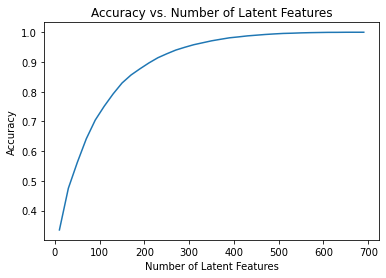

In [41]:
latent_features = np.arange(10,700+10,20)
sum_errors = []

for k in latent_features:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_estimate = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_estimate)
    
    # total errors and keep track of them
    error = np.sum(np.sum(np.abs(diffs)))
    sum_errors.append(error)
    
    
plt.plot(latent_features, 1 - np.array(sum_errors)/data.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from 3. to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [42]:
a = [1,2,3]
b = [1]
(set(a).intersection(set(b)))

{1}

In [43]:
data_train = data.head(40000)
data_test = data.tail(5993)

def test_and_train_user_item(data_train, data_test):
    '''
    INPUT:
    data_train - training dataframe
    data_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_id_list - all of the test user ids
    test_article_list - all of the test article ids
    
    '''
    user_item_train = get_user_item_matrix(data_train)
    user_item_test = get_user_item_matrix(data_test)
    train_id_list = user_item_train.index.unique().tolist()
    train_article_list = user_item_train.columns.unique().tolist()
    test_id_list = user_item_test.index.unique().tolist()
    test_article_list = user_item_test.columns.unique().tolist()
    user_item_test = user_item_test.loc[set(train_id_list).intersection(set(test_id_list)), set(train_article_list).intersection(set(test_article_list))]
    return user_item_train, user_item_test, test_id_list, test_article_list

user_item_train, user_item_test, test_id_list, test_article_list = test_and_train_user_item(data_train, data_test)

In [44]:
#number of articles/movies for which can we make predictions for in the test set
len(test_article_list)

574

In [45]:
#users can we make predictions for in the test set
user_item_test.shape[0]

20

In [46]:
#users in the test set we are not able to make predictions for because of the cold start problem
len(test_id_list) - user_item_test.shape[0]

662

In [47]:
#number of movies/articles in the test set are we not able to make predictions for because of the cold start problem
len(test_article_list) - user_item_test.shape[1]

0

In [49]:
#Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


5. Now using the user_item_train dataset from above to find U, S, and V transpose using SVD. Then finding the subset of rows in the user_item_test dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in 2. - 4.

In [50]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
vt_train.shape, s_train.shape, u_train.shape

((714, 714), (714,), (4487, 4487))

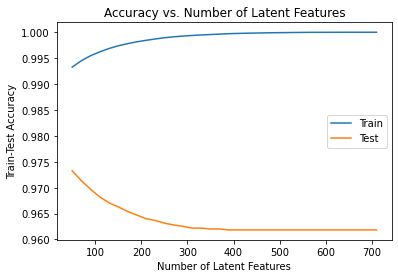

In [51]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

row_index = user_item_train.index.isin(test_id_list)
col_index = user_item_train.columns.isin(test_article_list)
u_test = u_train[row_index, :]
vt_test = vt_train[:, col_index]



number_latent_features = np.arange(50,700+30,20)

errors_train_list = []
errors_test_list = []

for i in number_latent_features:
    # restructure with k latent features
    s_train_latent, u_train_latent, vt_train_latent = np.diag(s_train[:i]), u_train[:, :i], vt_train[:i, :]
    u_test_latent, vt_test_latent = u_test[:, :i], vt_test[:i, :]
    
    #doing the dot product to get the user_item matrix
    user_item_train_predictions = np.around(np.dot(np.dot(u_train_latent, s_train_latent), vt_train_latent))
    user_item_test_predictions = np.around(np.dot(np.dot(u_test_latent, s_train_latent), vt_test_latent))
    
    #computing the difference between predicted and actual value for computing errors
    difference_train = np.subtract(user_item_train, user_item_train_predictions)
    difference_test = np.subtract(user_item_test, user_item_test_predictions)
    
    
    # total errors and keep track of them
    error_train = np.sum(np.sum(np.abs(difference_train)))
    error_test = np.sum(np.sum(np.abs(difference_test)))
    
    #appending to list
    errors_train_list.append(error_train)
    errors_test_list.append(error_test)


    
#plotting the accuracies
plt.plot(number_latent_features,1-np.array(errors_train_list)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(number_latent_features, 1 - np.array(errors_test_list)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.xlabel('Number of Latent Features');
plt.ylabel('Train-Test Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend()

`6.` Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles?

1. Firstly as we can see from the graph that with the increase in the number of latent feature there is a decrease in the accuracy but after around 400 latent feature the change is negligible. One of the main reason for this is that we are only predicting values for 20 users. As out data is too small it is difficult to predict correctly. If our dataset was huge we would have got better results.

2. The training accuracy seems to be approaching to 1 as the no. of features increases this might be because the model is trying to overfit the itself with the training data making itself for predicting data present in training.

3. To find that the recommendations made by above models are improved as compared to how users currently find article we can perform a A/B test here. We can split the users into experiment and controled group and then use our model to recommend articles to the experiment group. Then we can see is there an increase in the interactions made by users in experiment group as compared to control group. If there is an increase that means our recommendation system is better.

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0

# **Extras**
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results. These tasks are beyond what is required for this project. However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!